<a href="https://colab.research.google.com/github/UdeS-PMF/gmq710_test/blob/develop/opencv_ultralytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilisation de Ultralytics

## Objectifs

La librairie Ultralytics est une plateforme avancée dédiée au développement et à l'application de modèles de vision par ordinateur, tels que YOLO (You Only Look Once), pour des tâches comme la classification d'images, la détection d'objets, et la segmentation d'images.

On peut utiliser ce genre de librairie en Python pour développer une application.

On va mettre en place un exemple d'analyse de vidéo de circulation (pourrait venir d'une caméra). On souhaite analyser les images de la caméra et détecter quand un camion se présente sur un tronçon routier.

Prenons l'exemple ci-dessous, la zone rouge est une barrière virtuelle à ne pas franchir par un camion.

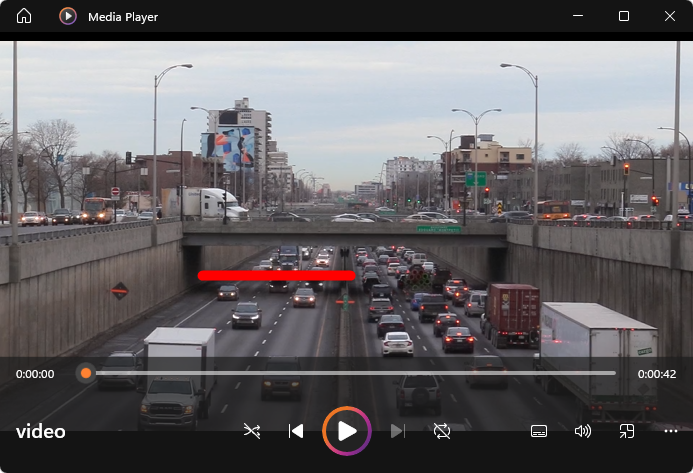

## Installation des librairies

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 kB 23.7 MB/s eta 0:00:00


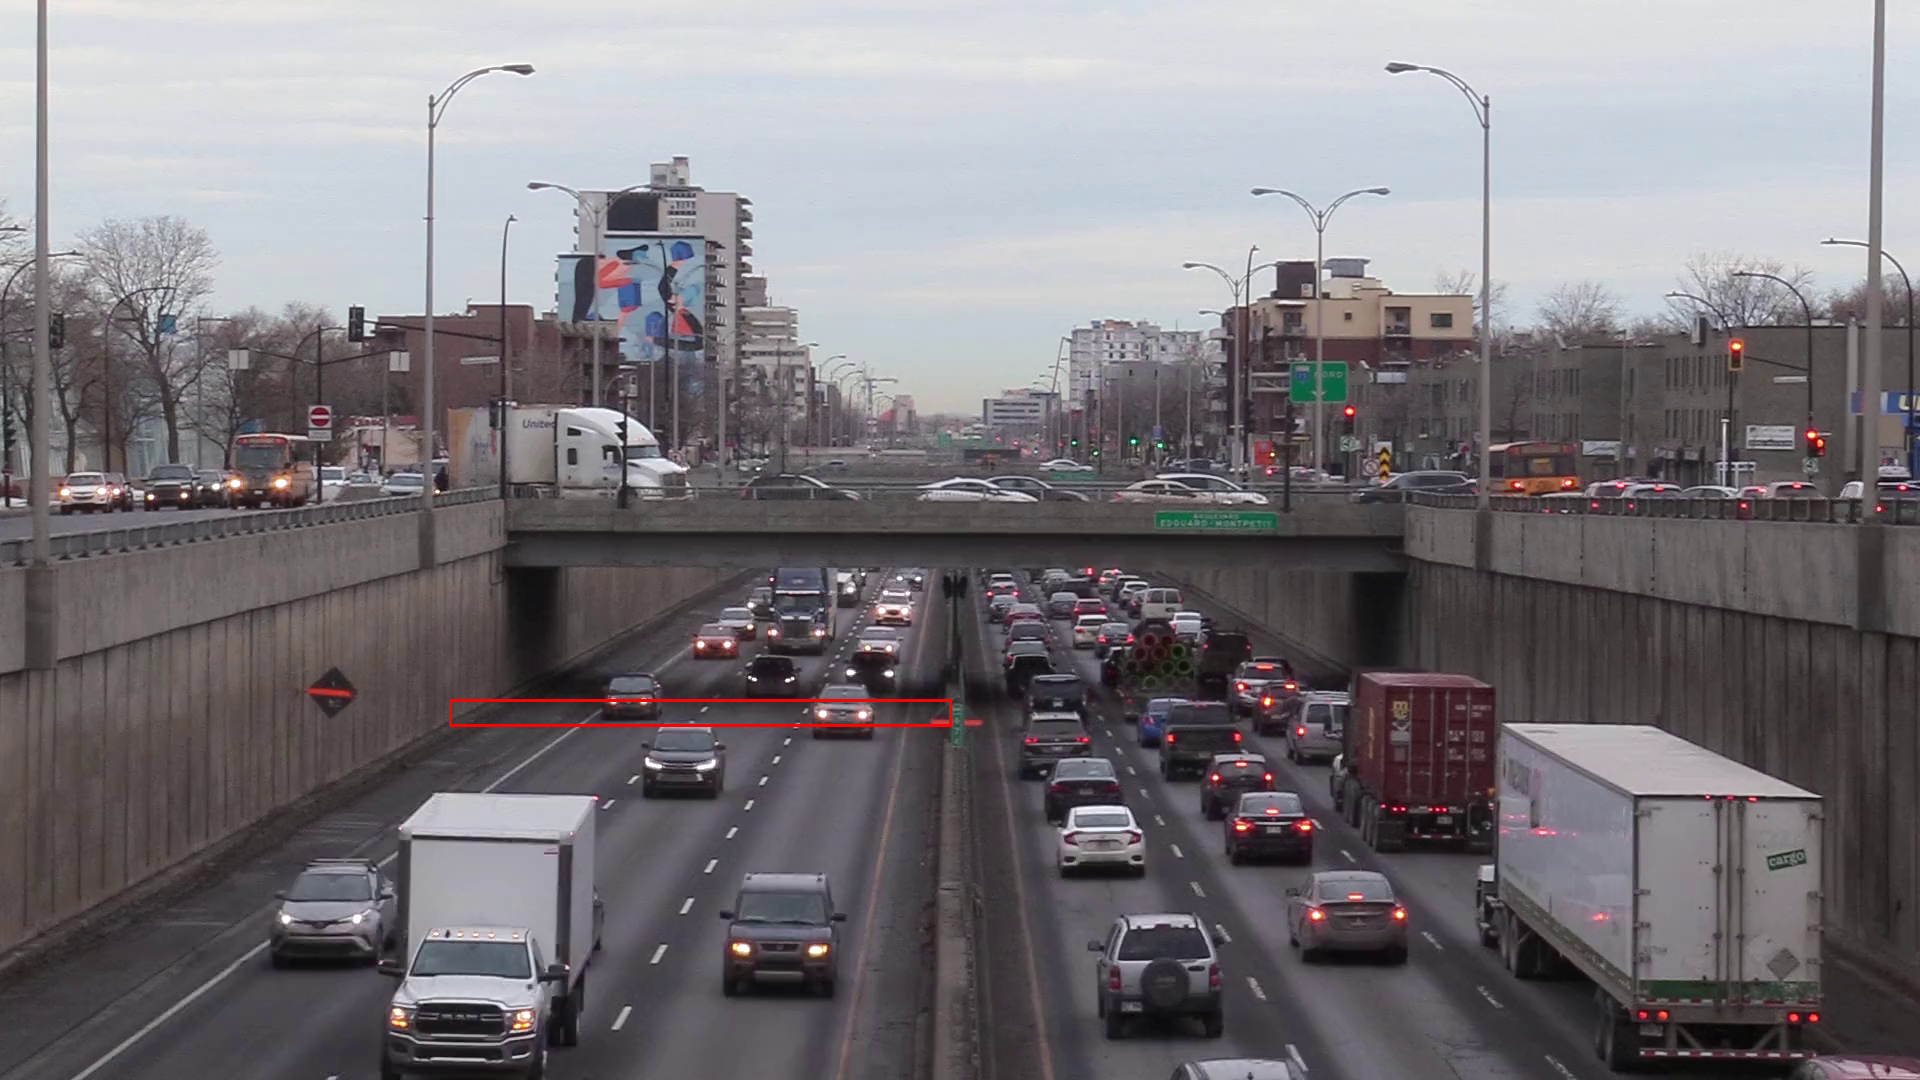

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

# Load the image
img = cv2.imread('/content/sample-image.png')

# Define the coordinates of the box
x, y, w, h = 450, 700, 500, 25  # Example coordinates

# Draw the box on the image
cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Green box with thickness 2

# Display the image (optional)
cv2_imshow( img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Notre application

On visualise la vidéo et on collecte les évènements quand un camion traverse la barrière virtuelle.

On peut vérifier les classes coco (https://github.com/pjreddie/darknet/blob/master/data/coco.names)

In [ ]:
import cv2

cap = cv2.VideoCapture("/content/video.mp4")
original_fps = cap.get(cv2.CAP_PROP_FPS)
print(original_fps)
desired_fps = 1

frame_interval = int(original_fps / desired_fps)
frame_count = 0
print(frame_interval)


29.97002997002997
29


In [ ]:
# créer un répertoire /content/results si il n'existe pas
import os
if not os.path.exists("/content/results"):
    os.makedirs("/content/results")

In [ ]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow

# définition de la zone d'exclusion
exclusion_box = 450, 700, 500, 25

# Charger le modèle YOLO
model = YOLO("yolo11n.pt") # le réseau est chargé automatiquement

# Ouvrir la vidéo
video = cv2.VideoCapture("/content/video.mp4")

original_fps = cap.get(cv2.CAP_PROP_FPS)

# on peut demander d'analyser une frame toutes les 15 frames
desired_fps = 15

frame_interval = int(original_fps / desired_fps)
frame_count = 0

# on peut récupérer les chemins des camions
truck_path = {}
while True:
    # Lire une frame de la vidéo
    ret, frame = video.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % frame_interval == 0:
        # Effectuer la détection et le suivi
        # les camions c'est la classe 7
        results = model.track(frame, persist=True, classes=[7])


        # Dessiner les boîtes englobantes et les ID
        for r in results:
            # on récupère les zones des objets
            boxes = r.boxes.xyxy.cpu().numpy().astype(int)
            print(boxes)

            if r.boxes.id is None:
                continue
            # on récupère les identifiants
            ids = r.boxes.id.cpu().numpy().astype(int)

            for box, id in zip(boxes, ids):

                # calculer l'intersection entre la zone d'exclusion et la zone du camion
                x1, y1, x2, y2 = box
                exclusion_x1, exclusion_y1, exclusion_w, exclusion_h = exclusion_box
                inter_x1 = max(x1, exclusion_x1)
                inter_y1 = max(y1, exclusion_y1)
                inter_x2 = min(x2, exclusion_x1 + exclusion_w)
                inter_y2 = min(y2, exclusion_y1 + exclusion_h)
                # si la zone du camion se retrouve dans la zone d'exclusion
                if inter_x1 < inter_x2 and inter_y1 < inter_y2:
                    # L'intersection existe
                    inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
                    box_area = (x2 - x1) * (y2 - y1)
                    overlap_ratio = inter_area / box_area

                    # dès qu'il y a intersection
                    if overlap_ratio > 0:
                      # on va créer une image avec une preuve
                      cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
                      cv2.putText(frame, f"ID: {id}", (box[0], box[1] - 10),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

                      # on sauvegarde l'image
                      cv2.imwrite(f"/content/results/image_{frame_count}.png", frame)

                      # on conserve la zone détectée pour pouvoir faire le chemin parcouru par le camion
                      if id not in truck_path:
                          truck_path[id] = [box]
                      else :
                          truck_path[id].append(box)
                elif id in truck_path:
                  truck_path[id].append(box)


        # Afficher la frame
        #cv2_imshow( frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
0: 384x640 3 trucks, 14.2ms
Speed: 3.1ms preprocess, 14.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
[[1373  713 1508  853]
 [ 385  742  636 1060]
 [1452  834 1572  934]]

0: 384x640 2 trucks, 15.4ms
Speed: 3.2ms preprocess, 15.4ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)
[[1368  707 1498  848]
 [ 336  766  610 1080]]

0: 384x640 2 trucks, 21.6ms
Speed: 3.5ms preprocess, 21.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
[[1360  703 1489  842]
 [ 278  794  579 1080]]

0: 384x640 2 trucks, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
[[1353  699 1479  833]
 [ 213  828  541 1080]]

0: 384x640 2 trucks, 17.9ms
Speed: 3.4ms preprocess, 17.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
[[1349  694 1472  824]
 [ 116  875  495 1080]]

0: 384x640 1 truck, 20.7ms
Speed: 

!!!attention !!! utiliser uniquement en connaissance de cause

In [ ]:
# remove all files in /content/results
import os
for file in os.listdir("/content/results"):
    os.remove(os.path.join("/content/results", file))



Comme on a les détections des camions, on peut retracer leur chemin

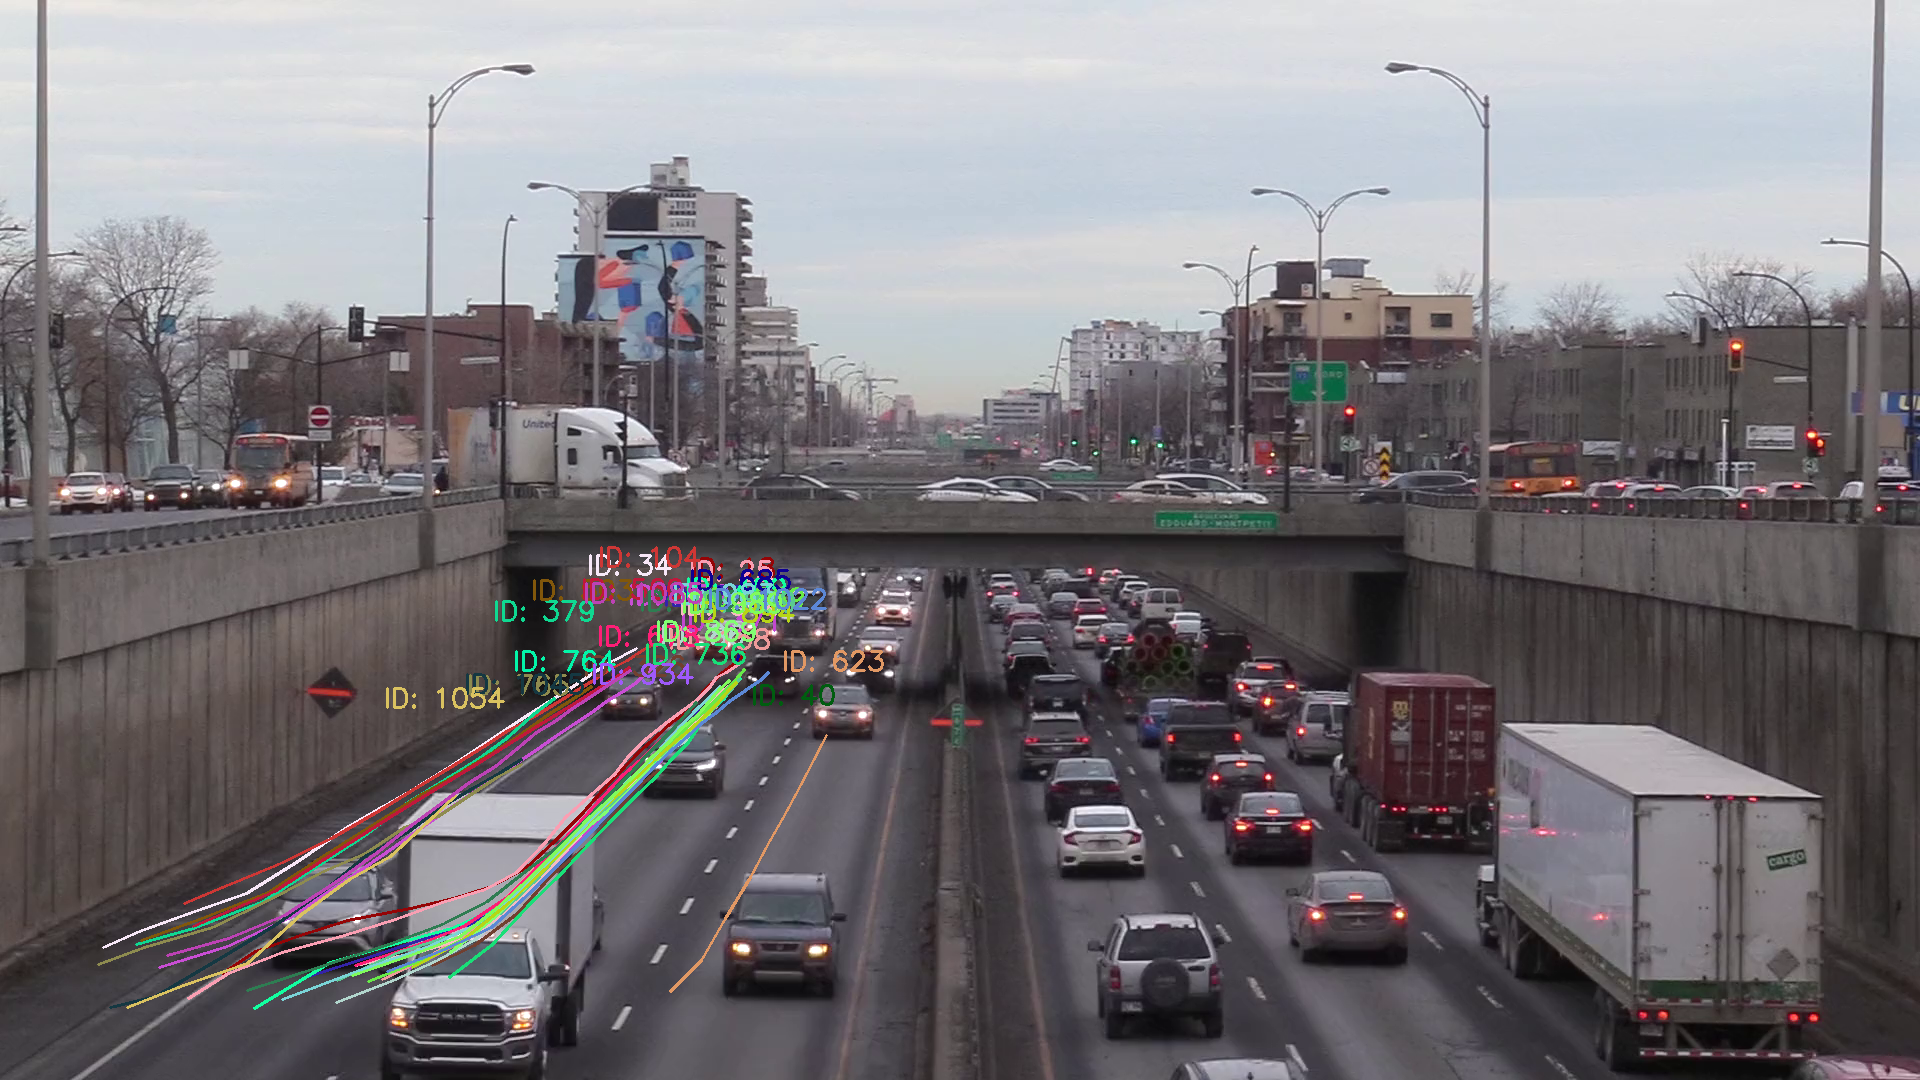

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import random
# On prend une image de la caméra
img = cv2.imread('/content/sample-image.png')

# on parcourt le dictionnaire avec les ids des camions et la liste des détections
for id, boxes in truck_path.items():
  # choisir une couleur au hasard
  color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
  # on pourra positionner un texte
  x0 = boxes[0][0]
  y0 = boxes[0][1]
  # on parcourt les zones détectées
  for index, box in enumerate(boxes[:-1]):

    x1, y1, x2, y2 = box
    x3, y3, x4, y4 = boxes[index+1]
    # calcul le centre de la boite
    xc = (x1 + x2) // 2
    yc = (y1 + y2) // 2

    # calcul le centre de la boite suivante
    xc2 = (x3 + x4) // 2
    yc2 = (y3 + y4) // 2



    # trace une ligne
    cv2.line(img, (xc, yc), (xc2, yc2), color, 2)
  cv2.putText(img, f"ID: {id}", (x0, y0 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)


# Display the image (optional)
cv2_imshow( img)
cv2.waitKey(0)
cv2.destroyAllWindows()